In [2]:
import sys
sys.path.append("../lropy")

%load_ext autoreload
%autoreload complete

In [3]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import LogLocator
import pandas as pd
import numpy as np
import seaborn as sb
import spiceypy as spice

from datetime import datetime, timedelta, timezone
from pathlib import Path

In [4]:
from lropy.analysis.spice_tools import as_et, as_utc, as_tdb, generate_lro_ephemeris
from lropy.analysis.io import load_simulation_results, load_all_simulation_results, load_pickled_simulation_results, pos_names, vel_names, acc_names, irr_names, panels_count_names
from lropy.analysis.plotting import format_plot, save_plot
from lropy.analysis.transform import spher2cart, cart2spher, align_vectors
from lropy.analysis.util import get_day_index, trim_df, get_revolutions_index
from lropy.constants import moon_polar_radius

In [5]:
def plot_accelerations(dfs, labels):
    fig, axs = plt.subplots(4, 1, figsize=(12, 8), sharex="all")
    ax_mag, ax_radial, ax_along, ax_cross = axs

    for df, label in zip(dfs, labels):
        ax_mag.plot(df.index, df["acc_rp_moon"], label=label)
        ax_radial.plot(df.index, df["acc_rp_moon_radial"])
        ax_along.plot(df.index, df["acc_rp_moon_along"])
        ax_cross.plot(df.index, df["acc_rp_moon_cross"])

    ax_mag.set_title("magnitude")
    ax_radial.set_title("radial")
    ax_along.set_title("along")
    ax_cross.set_title("cross")
    ax_mag.legend()

    for ax in axs.flat:
        ax.tick_params(axis='x', labelrotation=45)
        ax.set_ylim([min(0, ax.get_ylim()[0]), ax.get_ylim()[1]])
    
    format_plot()

# Effect of instantaneous reradiation

In [6]:
results_folder_rerad = Path("../results/instantaneous_reradiation_test-2023-08-15T20-10-45-a0604")
metadata_rerad, runs_rerad = load_pickled_simulation_results(results_folder_rerad)

In [7]:
metadata_rerad

,id,hostname,start_timestamp,save_dir,simulation_start,target_type,with_instantaneous_reradiation,use_occultation,use_solar_radiation,use_moon_radiation,paneling_moon,number_of_panels_moon,number_of_panels_per_ring_moon,albedo_distribution_moon,thermal_type_moon,simulation_duration,step_size,save_results,walltime_propagation,walltime_total
1,0c7d2,eudoxos,2023-08-15T20:10:45.690574,/home2/dominik/dev/lropy/results/instantaneous...,2010 SEP 26 06:00:00,Paneled,True,True,True,True,Dynamic,0,"[6, 12, 18, 24, 30]",Constant,AngleBased,13563.4,10,True,9.201329,[11.25755175948143]
2,46d38,eudoxos,2023-08-15T20:10:45.690614,/home2/dominik/dev/lropy/results/instantaneous...,2010 SEP 26 06:00:00,Paneled,False,True,True,True,Dynamic,0,"[6, 12, 18, 24, 30]",Constant,AngleBased,13563.4,10,True,9.04384,[11.079669242724776]
3,661f0,eudoxos,2023-08-15T20:10:45.690629,/home2/dominik/dev/lropy/results/instantaneous...,2010 SEP 26 06:00:00,Paneled,True,True,False,False,,0,[],,,13563.4,10,True,7.998641,[10.029750237241387]


In [8]:
df_with_rerad = runs_rerad[metadata_rerad[metadata_rerad["use_moon_radiation"] & metadata_rerad["with_instantaneous_reradiation"]].index[0]]
df_without_rerad = runs_rerad[metadata_rerad[metadata_rerad["use_moon_radiation"] & ~metadata_rerad["with_instantaneous_reradiation"]].index[0]]

In [9]:
def plot_rp(source):
    fig, axs = plt.subplots(3, figsize=(12, 6))

    for comp, ax in zip(["radial", "along", "cross"], axs):
        ax.set_title(comp)
        ax.plot(df_with_rerad.index, df_with_rerad[f"acc_rp_{source}_{comp}"], label="With instantaneous reradiation")
        ax.plot(df_without_rerad.index, df_without_rerad[f"acc_rp_{source}_{comp}"], label="Without instantaneous reradiation")
        ax.plot(df_without_rerad.index, df_without_rerad[f"acc_rp_{source}_{comp}"] * df_with_rerad[f"acc_rp_{source}_{comp}"].max() / df_without_rerad[f"acc_rp_{source}_{comp}"].max(), label="Without instantaneous reradiation (scaled))")

    axs[0].legend()

    format_plot()

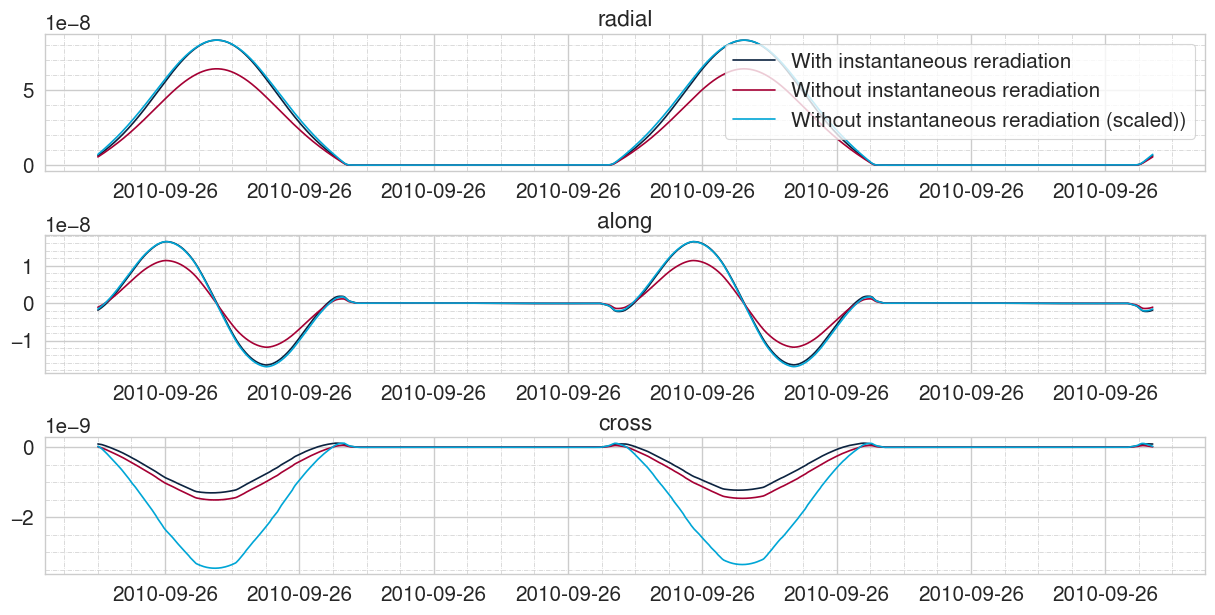

In [10]:
plot_rp("moon")

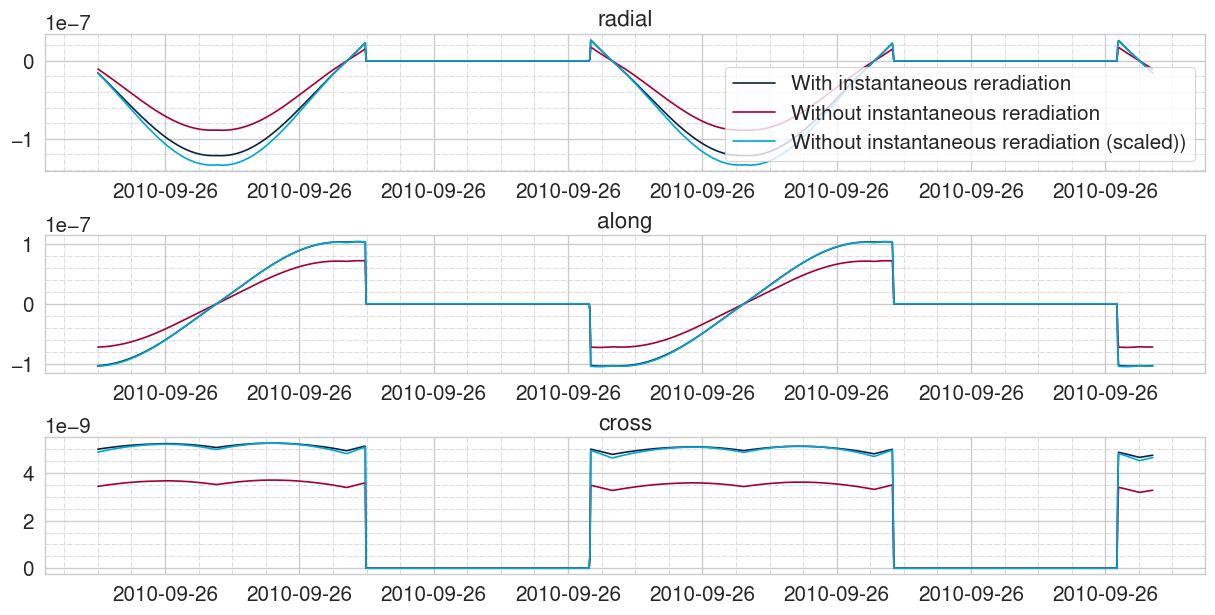

In [11]:
plot_rp("sun")

Shape of both is slightly different, i.e. instantaneous reradiation is not simply a factor.

# Relative contribution of albedo and thermal

In [12]:
results_folder_contribs = Path("../results/albedo_thermal_test-2023-08-15T19-54-12-f3789")
metadata_contribs, runs_contribs = load_pickled_simulation_results(results_folder_contribs)

In [13]:
metadata_contribs

,id,hostname,start_timestamp,save_dir,simulation_start,target_type,with_instantaneous_reradiation,use_occultation,use_solar_radiation,use_moon_radiation,paneling_moon,number_of_panels_moon,number_of_panels_per_ring_moon,albedo_distribution_moon,thermal_type_moon,simulation_duration,step_size,save_results,walltime_propagation,walltime_total
1,b4f41,eudoxos,2023-08-15T19:54:12.244650,/home2/dominik/dev/lropy/results/albedo_therma...,2010 AUG 04 06:00:00,Cannonball,False,True,True,True,Dynamic,0,"[6, 12, 18, 24, 30]",Constant,AngleBased,13563.4,10,True,16.764033,[19.071797497570515]
2,8cb61,eudoxos,2023-08-15T19:54:12.244691,/home2/dominik/dev/lropy/results/albedo_therma...,2010 AUG 04 06:00:00,Paneled,False,True,True,True,Dynamic,0,"[6, 12, 18, 24, 30]",Constant,Delayed,13563.4,10,True,11.184279,[13.491177862510085]
3,7f5ad,eudoxos,2023-08-15T19:54:12.244705,/home2/dominik/dev/lropy/results/albedo_therma...,2010 JUN 26 06:00:00,Cannonball,False,True,True,True,Dynamic,0,"[6, 12, 18, 24, 30]",DLAM1,Delayed,13563.4,10,True,22.542855,[24.60912188142538]
4,e6fdd,eudoxos,2023-08-15T19:54:12.244718,/home2/dominik/dev/lropy/results/albedo_therma...,2010 JUN 26 06:00:00,Paneled,False,True,True,True,Dynamic,0,"[6, 12, 18, 24, 30]",NoAlbedo,AngleBased,13563.4,10,True,17.074574,[19.428560746833682]
5,9c534,eudoxos,2023-08-15T19:54:12.244729,/home2/dominik/dev/lropy/results/albedo_therma...,2010 AUG 04 06:00:00,Cannonball,False,True,True,True,Dynamic,0,"[6, 12, 18, 24, 30]",DLAM1,Delayed,13563.4,10,True,15.547938,[17.561371590942144]
6,3e651,eudoxos,2023-08-15T19:54:12.244740,/home2/dominik/dev/lropy/results/albedo_therma...,2010 JUN 26 06:00:00,Paneled,False,True,True,True,Dynamic,0,"[6, 12, 18, 24, 30]",Constant,AngleBased,13563.4,10,True,17.361292,[19.51433749869466]
7,ec79a,eudoxos,2023-08-15T19:54:12.244753,/home2/dominik/dev/lropy/results/albedo_therma...,2010 JUN 26 06:00:00,Paneled,False,True,True,True,Dynamic,0,"[6, 12, 18, 24, 30]",DLAM1,NoThermal,13563.4,10,True,22.543873,[24.698894750326872]
8,4bc3e,eudoxos,2023-08-15T19:54:12.244767,/home2/dominik/dev/lropy/results/albedo_therma...,2010 SEP 26 06:00:00,Cannonball,False,True,True,True,Dynamic,0,"[6, 12, 18, 24, 30]",Constant,AngleBased,13563.4,10,True,16.646553,[19.030714098364115]
9,af10e,eudoxos,2023-08-15T19:54:12.244780,/home2/dominik/dev/lropy/results/albedo_therma...,2010 AUG 04 06:00:00,Paneled,False,True,True,True,Dynamic,0,"[6, 12, 18, 24, 30]",DLAM1,Delayed,13563.4,10,True,16.123088,[18.219489216804504]
10,1ead9,eudoxos,2023-08-15T19:54:12.244791,/home2/dominik/dev/lropy/results/albedo_therma...,2010 JUN 26 06:00:00,Cannonball,False,True,True,True,Dynamic,0,"[6, 12, 18, 24, 30]",NoAlbedo,Delayed,13563.4,10,True,16.621963,[19.02074901200831]


In [14]:
def get_contrib_run(albedo, thermal, target_type, start_date):
    for date in metadata_contribs["simulation_start"].unique():
        if date.startswith(start_date):
            start_date = date
            break

    idx = metadata_contribs[
        (metadata_contribs["albedo_distribution_moon"] == albedo) &
        (metadata_contribs["thermal_type_moon"] == thermal) &
        (metadata_contribs["target_type"] == target_type) &
        (metadata_contribs["simulation_start"] == start_date)
    ]
    if len(idx.index) > 1:
        raise ValueError("More than one run found")
    return runs_contribs[idx.index[0]]

### Orbital period

6778.236288870079 6783.353280815105 6780.705217881679 113.01175363136132
6778.776481382661 6786.21909355326 6782.367691800741 113.03946153001236
6778.661937575046 6786.992394649099 6782.666542363667 113.04444237272779


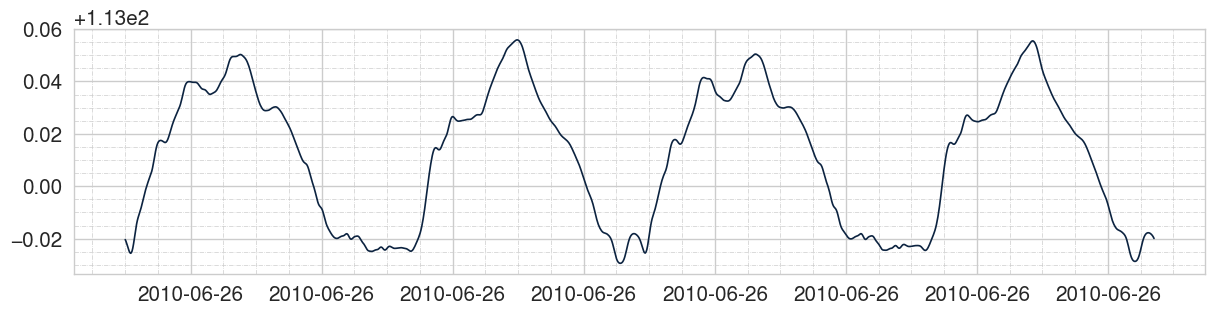

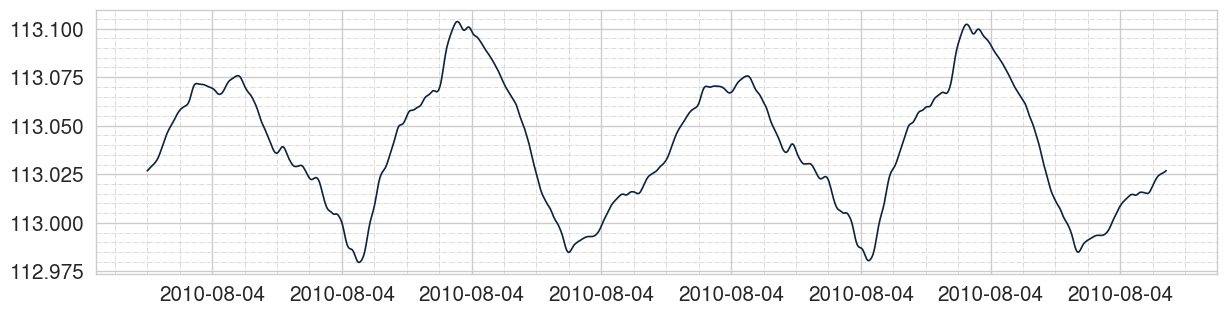

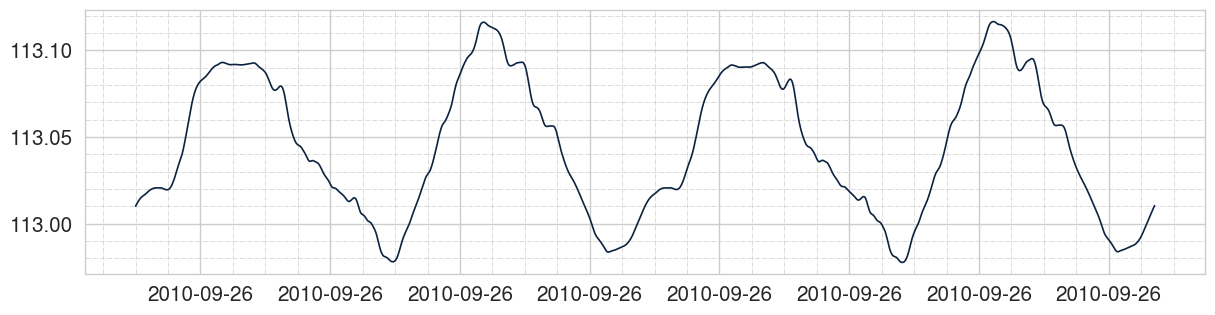

In [15]:
def plot_orbital_period(date):
    gm_moon = 4.9048695e12
    df = get_contrib_run("DLAM1", "AngleBased", "Paneled", date)

    period = np.sqrt(df["kepler_a"]**3 / gm_moon) * 2 * np.pi
    print(period.min(), period.max(), period.mean(), period.mean() / 60)

    plt.subplots()
    plt.plot(df.index, period / 60)

    format_plot()

plot_orbital_period("2010 JUN 26")
plot_orbital_period("2010 AUG 04")
plot_orbital_period("2010 SEP 26")

### Solar vs lunar albedo

Expected solar RP acceleration from Lucchesi (2006) Eq. 2:

In [16]:
distance_moon_sun = 152460762e3  # m
sun_luminosity = 3.828e26  # W
solar_irradiance = sun_luminosity / (4 * np.pi * distance_moon_sun**2)
c = 299792458  # m/s
radiation_pressure = solar_irradiance / c

14.0 / 1087 * 1.0 * radiation_pressure

5.630198174778997e-08

which agrees with Smith's results and ours for cannonball (with mass 1208 and area 11.5 m2). Our paneled results correspond to a cannonball coefficient of 1.6, which can occur (Mazarico 2018, Fig. 15).

Expected albedo RP acceleration from Lucchesi (2006) Eq. 17:

In [17]:
0.15 / 2 * (moon_polar_radius / (moon_polar_radius + 50))**2 * 5.63e-8

4.2222567789410525e-09

which agrees with our results, not Smiths.
* Factor 1/2 in expected albedo RP probably due to ratio 1/2 of visible projected disk area to irradiated hemisphere area

55.73214254593588
5.688080958364225e-08
0.0 1323.99998568469


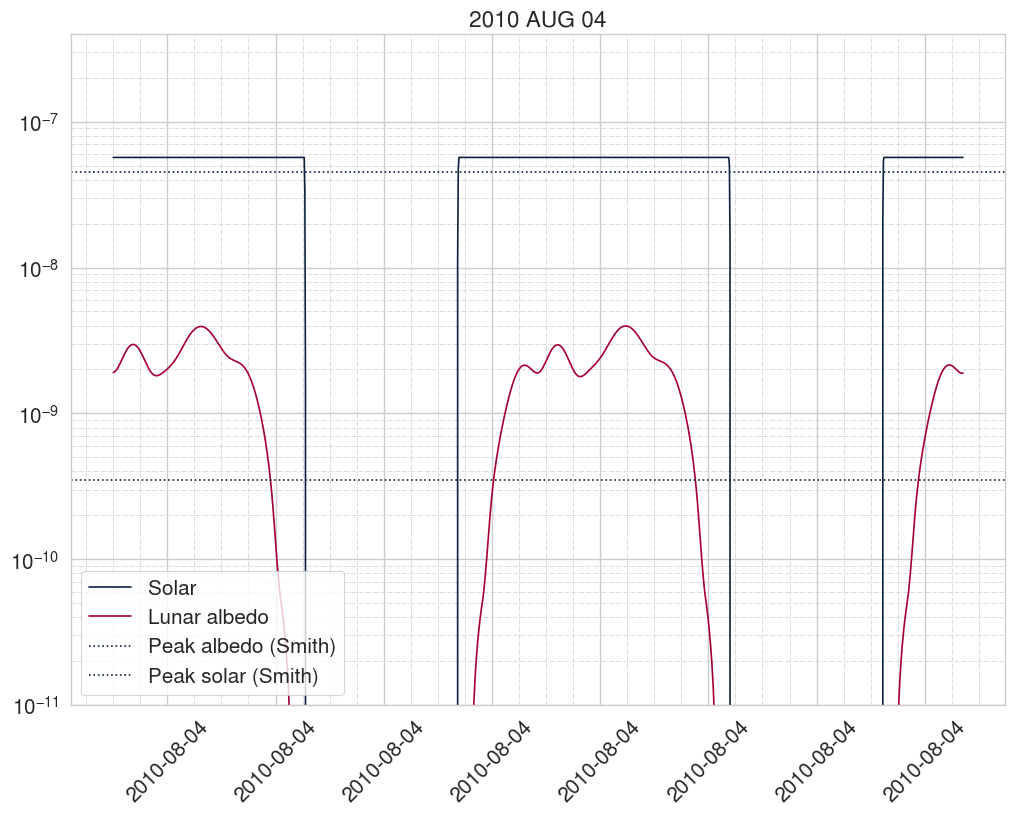

In [18]:
def plot_solar_vs_albedo():
    # start_date = "2010 AUG 26"
    start_date = "2010 AUG 04"
    df = get_contrib_run("DLAM1", "NoThermal", "Cannonball", start_date)
    
    fig, ax = plt.subplots(1, 1, figsize=(10, 8), sharex="all")

    ax.plot(df.index, df["acc_rp_sun"], label="Solar")
    ax.plot(df.index, df["acc_rp_moon"], label="Lunar albedo")
    print(df["angle_subsolar"].min())
    print(df["acc_rp_sun"].max())
    print(df["irr_sun"].min(), df["irr_sun"].max())

    ax.axhline(3.5e-10, label="Peak albedo (Smith)", ls=":")
    ax.axhline(4.5e-8, label="Peak solar (Smith)", ls=":")

    ax.legend()
    ax.set_title(start_date)

    ax.tick_params(axis='x', labelrotation=45)
    ax.set_ylim([1e-11, 4e-7])
    ax.set_yscale("log")
    
    format_plot()

plot_solar_vs_albedo()

Considerations for finding arc from Smith (2008):
* In their figure, 64% of orbit is not eclipsed. This occurs around August 4. Around August 29, 59% of the orbit is not eclipsed.
* February arc with 64% non-eclipse has very different albedo behavior -> must be August 4

### DLAM-1 vs constant albedo

In [19]:
def plot_albedo_type(start_date):
    df_albedo_constant = get_contrib_run("Constant", "NoThermal", "Cannonball", start_date)
    df_albedo_dlam = get_contrib_run("DLAM1", "NoThermal", "Cannonball", start_date)
    plot_accelerations([df_albedo_constant, df_albedo_dlam], ["Constant", "DLAM-1"])

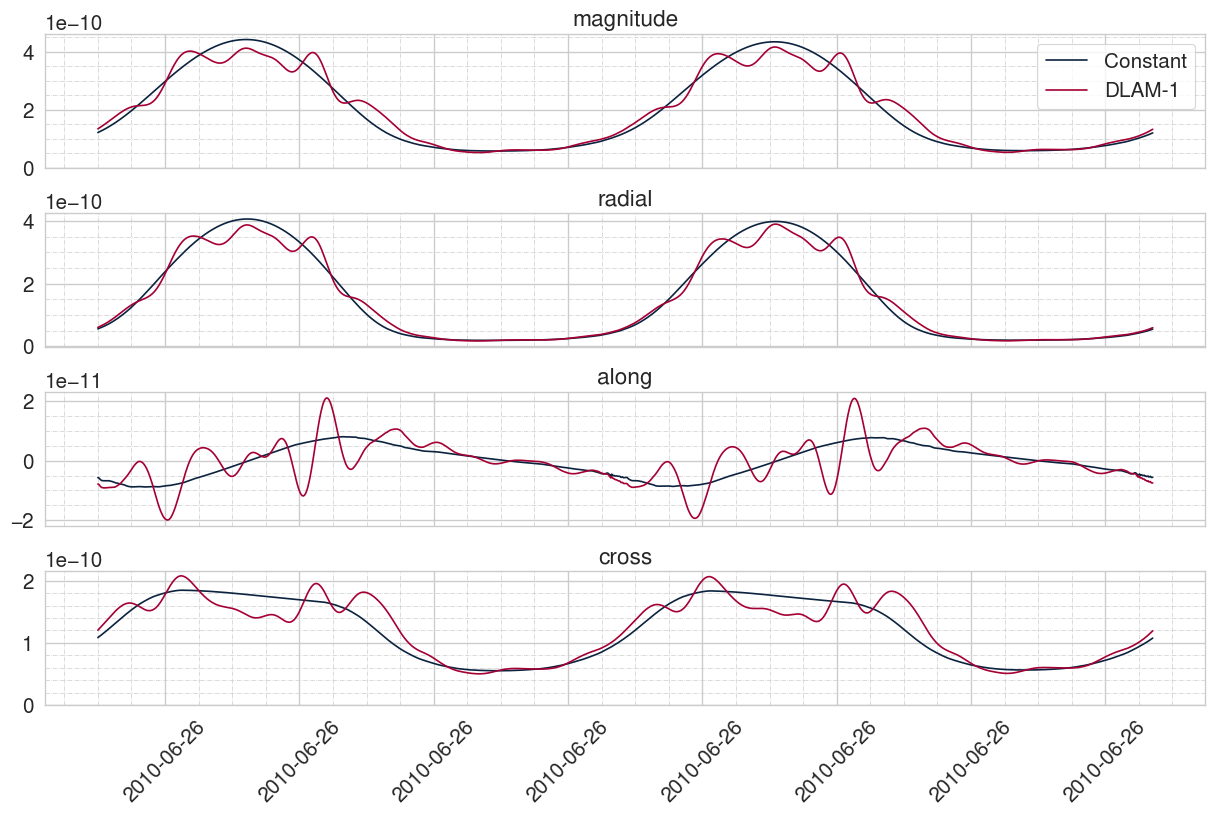

In [20]:
plot_albedo_type("2010 JUN 26")

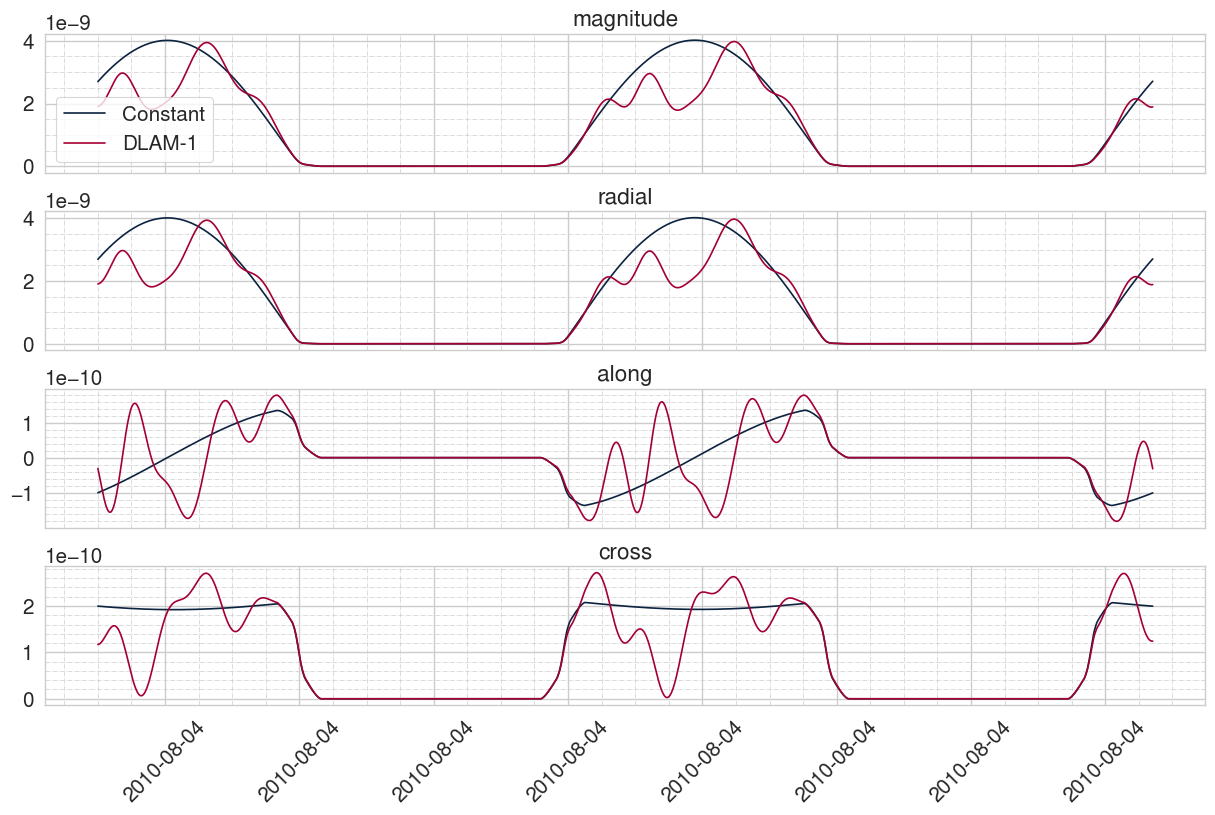

In [21]:
plot_albedo_type("2010 AUG 04")

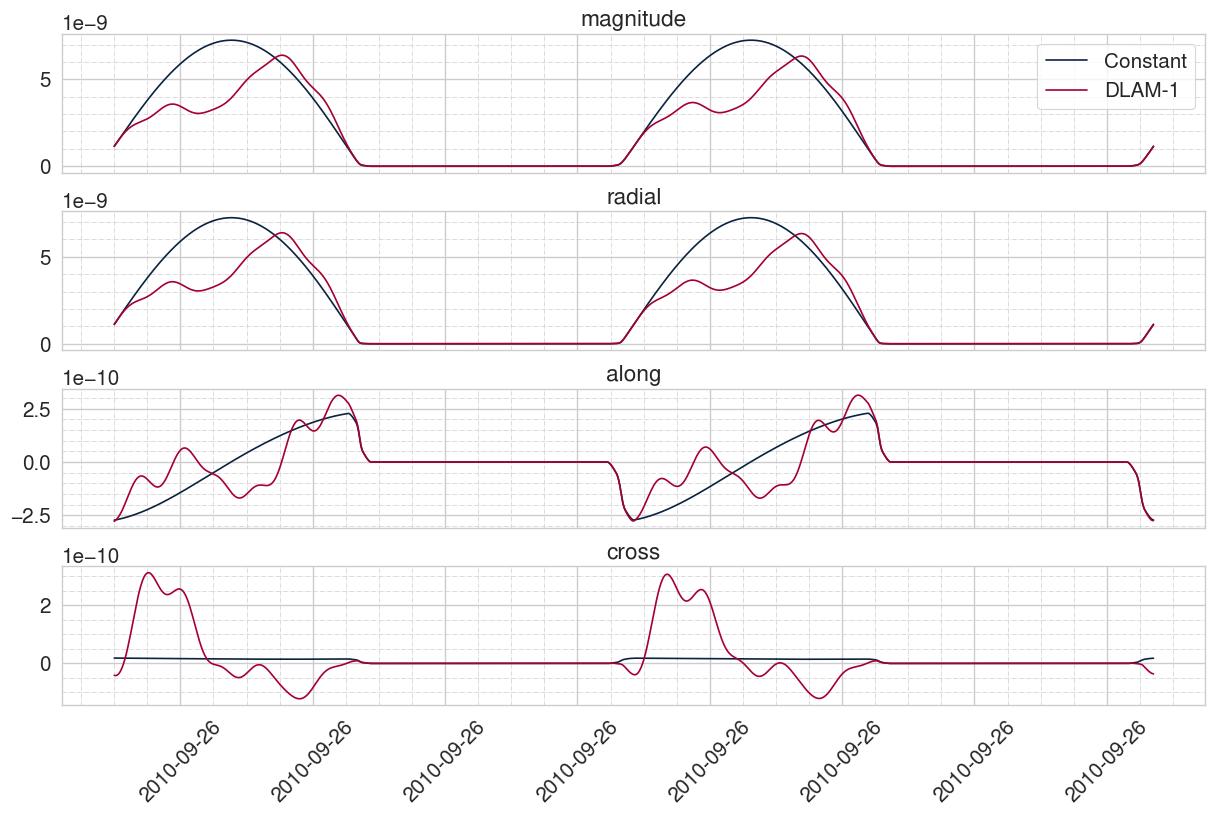

In [22]:
plot_albedo_type("2010 SEP 26")

### Delayed vs angle-based thermal radiation

In [23]:
def plot_thermal_type(start_date):
    df_albedo_angle_based = get_contrib_run("NoAlbedo", "AngleBased", "Cannonball", start_date)
    df_albedo_delayed = get_contrib_run("NoAlbedo", "Delayed", "Cannonball", start_date)
    plot_accelerations([df_albedo_angle_based, df_albedo_delayed], ["Angle-based", "Delayed"])

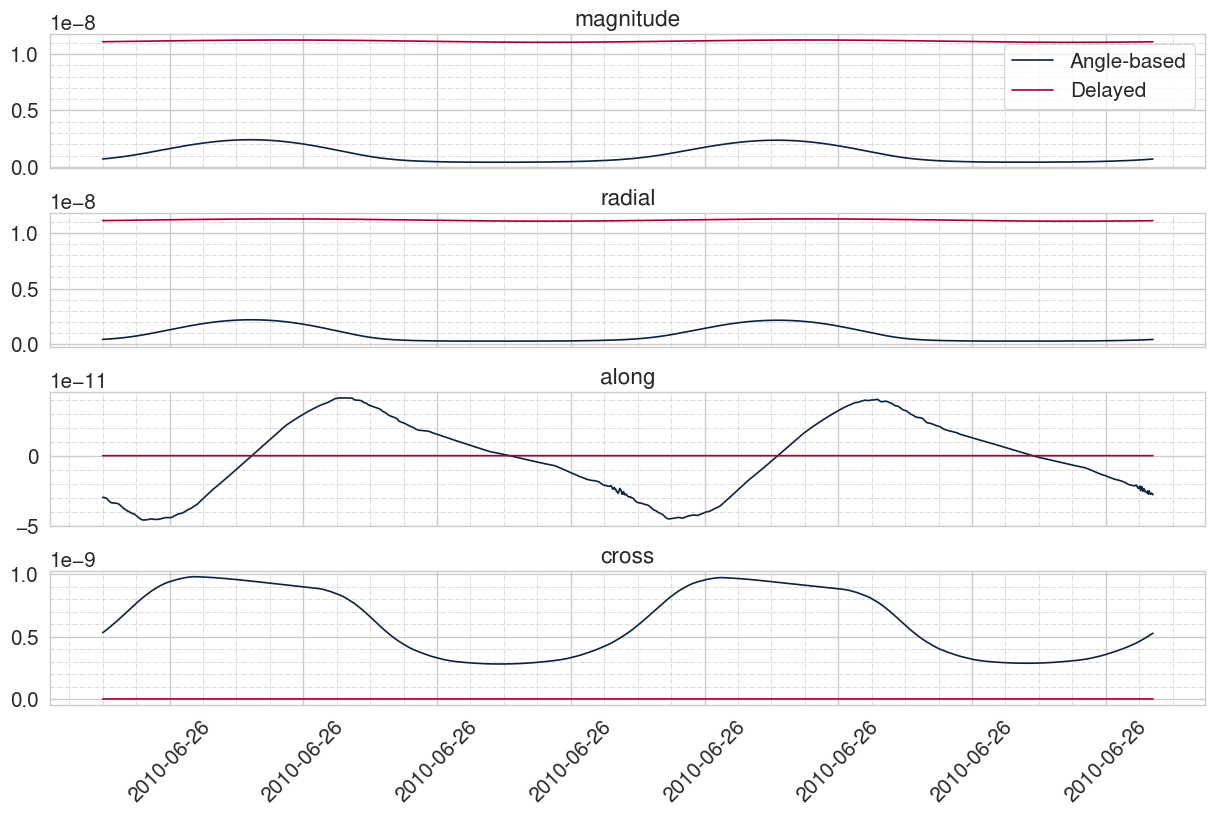

In [24]:
plot_thermal_type("2010 JUN 26")

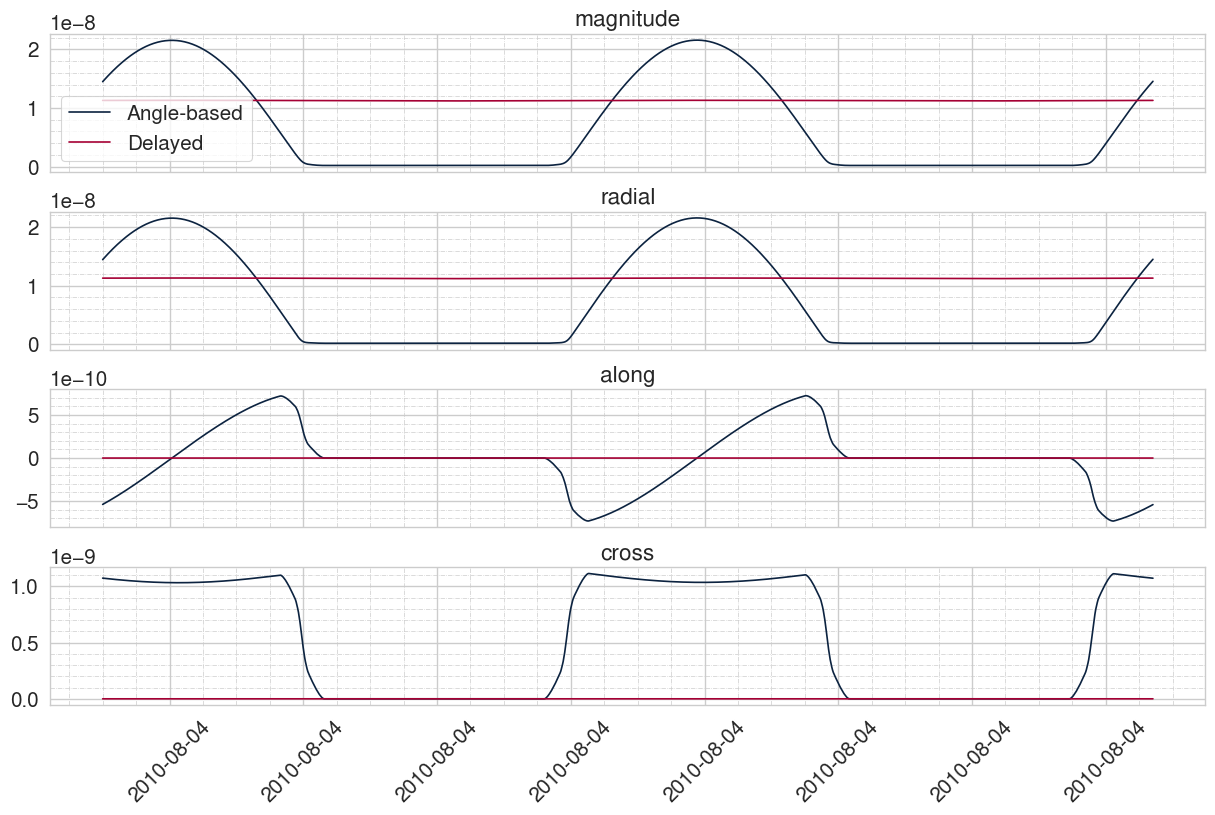

In [25]:
plot_thermal_type("2010 AUG 04")

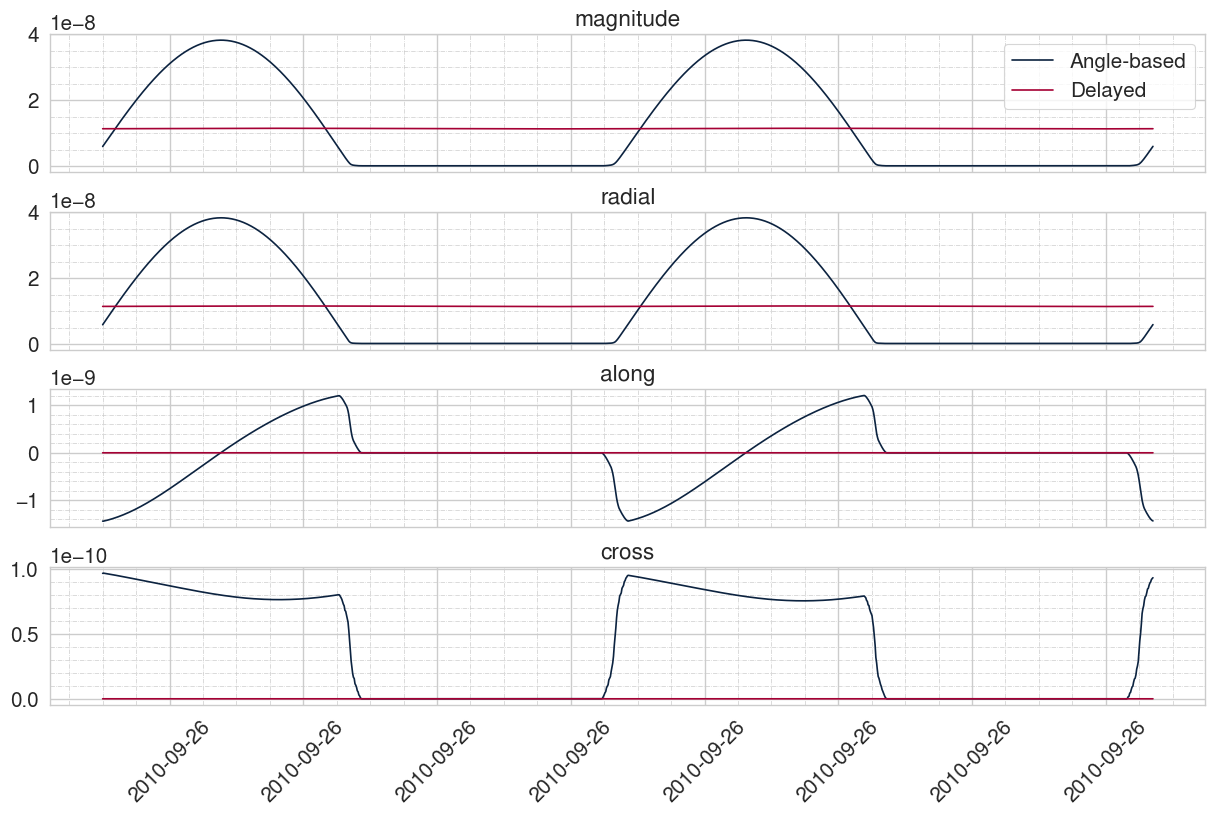

In [26]:
plot_thermal_type("2010 SEP 26")

Delayed model has constant radial acceleration and no cross/along acceleration since emissivity is constant.

### Albedo vs thermal radiation

In [27]:
def plot_albedo_vs_thermal(start_date):
    df_albedo = get_contrib_run("DLAM1", "NoThermal", "Cannonball", start_date)
    df_thermal = get_contrib_run("NoAlbedo", "AngleBased", "Cannonball", start_date)
    plot_accelerations([df_albedo, df_thermal], ["Albedo (DLAM-1)", "Thermal (angle-based)"])

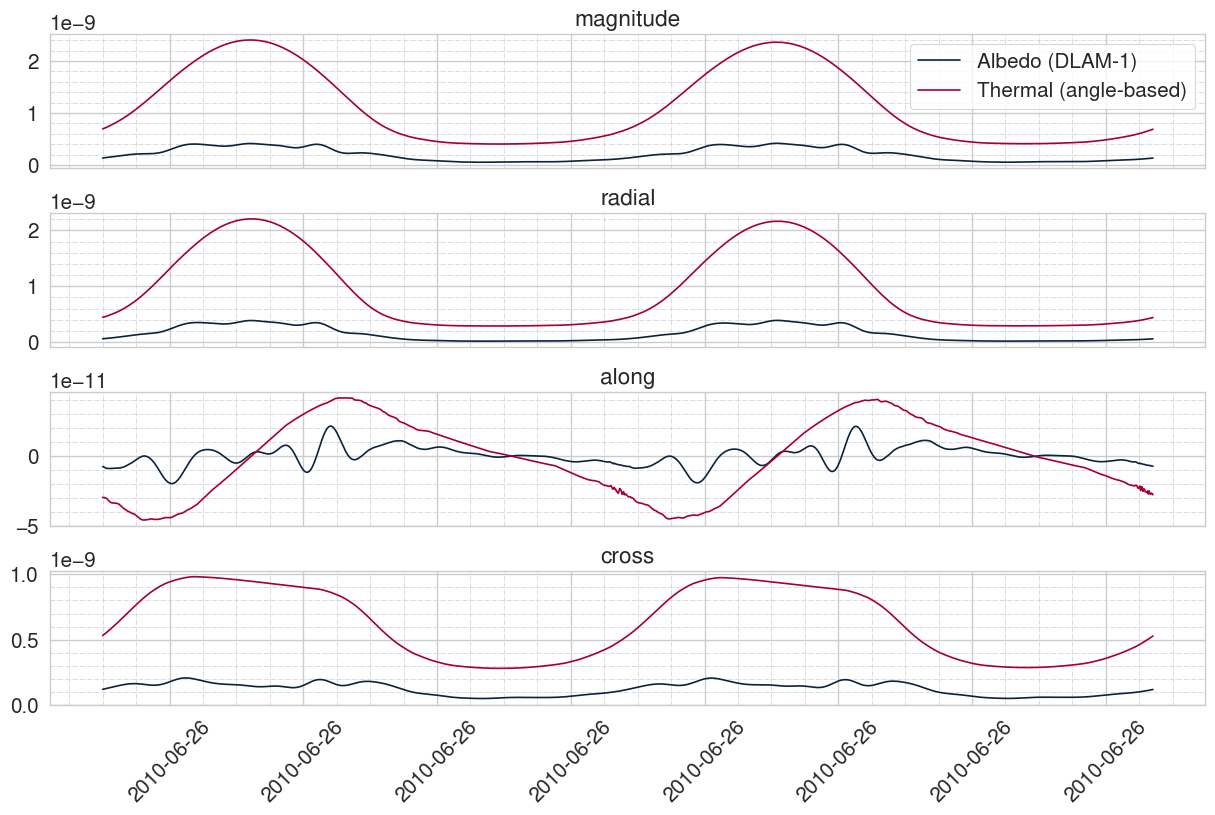

In [28]:
plot_albedo_vs_thermal("2010 JUN 26")

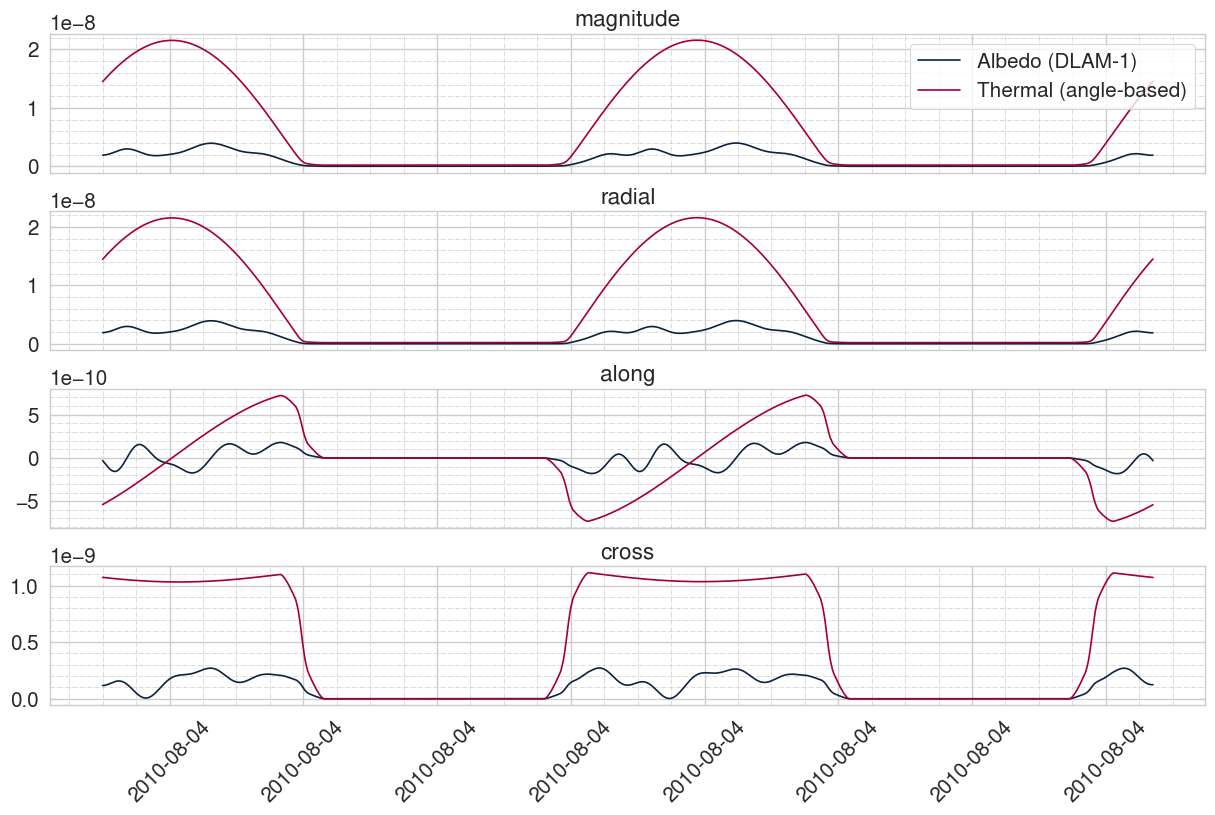

In [29]:
plot_albedo_vs_thermal("2010 AUG 04")

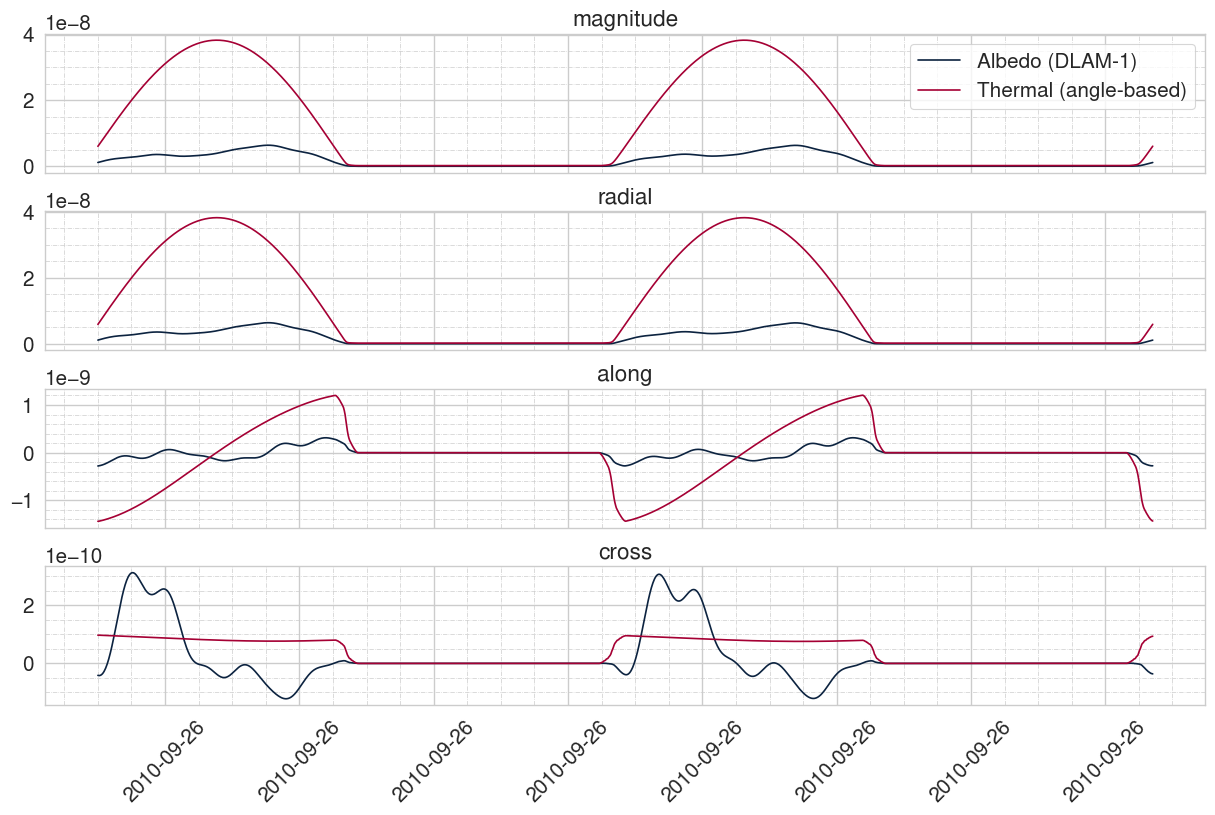

In [30]:
plot_albedo_vs_thermal("2010 SEP 26")

# Effect of number of rings

In [31]:
results_folder_rings = Path("../results/number_of_panels_per_ring_test-2023-08-17T14-33-31-ffcd7/")
metadata_rings, runs_rings = load_pickled_simulation_results(results_folder_rings)

In [32]:
metadata_rings

,id,hostname,start_timestamp,save_dir,simulation_start,target_type,with_instantaneous_reradiation,use_occultation,use_solar_radiation,use_moon_radiation,paneling_moon,number_of_panels_moon,number_of_panels_per_ring_moon,albedo_distribution_moon,thermal_type_moon,simulation_duration,step_size,save_results,walltime_propagation,walltime_total
1,63707,eudoxos,2023-08-17T14:33:31.755338,/home2/dominik/dev/lropy/results/number_of_pan...,2010 AUG 26 06:00:00,Cannonball,False,True,True,True,Dynamic,0,"[6, 12, 18, 24, 30]",DLAM1,AngleBased,13563.4,10,True,15.841007,[16.603067522868514]
2,f9aba,eudoxos,2023-08-17T14:33:31.755365,/home2/dominik/dev/lropy/results/number_of_pan...,2010 AUG 26 06:00:00,Cannonball,False,True,True,True,Dynamic,0,"[6, 12, 18, 24, 30, 36]",Constant,AngleBased,13563.4,10,True,10.70469,[11.465850479900837]
3,0fbfc,eudoxos,2023-08-17T14:33:31.755384,/home2/dominik/dev/lropy/results/number_of_pan...,2010 AUG 26 06:00:00,Cannonball,False,True,True,True,Dynamic,0,"[6, 12, 18, 24, 30, 36, 42, 48, 56, 60, 66, 72...",DLAM1,AngleBased,13563.4,10,True,53.352015,[54.10110993869603]
4,72c19,eudoxos,2023-08-17T14:33:31.755397,/home2/dominik/dev/lropy/results/number_of_pan...,2010 AUG 26 06:00:00,Cannonball,False,True,True,True,Dynamic,0,"[6, 12, 18, 24, 30, 36, 42, 48, 56]",Constant,AngleBased,13563.4,10,True,12.178729,[12.936120184138417]
5,31113,eudoxos,2023-08-17T14:33:31.755409,/home2/dominik/dev/lropy/results/number_of_pan...,2010 AUG 26 06:00:00,Cannonball,False,True,True,True,Dynamic,0,"[6, 12, 18, 24, 30, 36, 42, 48, 56, 60, 66, 72...",DLAM1,AngleBased,13563.4,10,True,43.164216,[43.917736418545246]
6,b4822,eudoxos,2023-08-17T14:33:31.755420,/home2/dominik/dev/lropy/results/number_of_pan...,2010 AUG 26 06:00:00,Cannonball,False,True,True,True,Dynamic,0,"[6, 12, 18, 24, 30, 36, 42, 48, 56, 60, 66, 72...",Constant,AngleBased,13563.4,10,True,16.589568,[17.35687855631113]
7,54d77,eudoxos,2023-08-17T14:33:31.755433,/home2/dominik/dev/lropy/results/number_of_pan...,2010 AUG 26 06:00:00,Cannonball,False,True,True,True,Dynamic,0,"[6, 12, 18, 24, 30, 36, 42, 48, 56, 60, 66]",Constant,AngleBased,13563.4,10,True,13.480387,[14.23343831859529]
8,b090f,eudoxos,2023-08-17T14:33:31.755448,/home2/dominik/dev/lropy/results/number_of_pan...,2010 AUG 26 06:00:00,Cannonball,False,True,True,True,Dynamic,0,"[6, 12, 18, 24, 30, 36, 42, 48, 56, 60, 66, 72...",Constant,AngleBased,13563.4,10,True,15.754013,[16.511640552431345]
9,2806a,eudoxos,2023-08-17T14:33:31.755460,/home2/dominik/dev/lropy/results/number_of_pan...,2010 AUG 26 06:00:00,Cannonball,False,True,True,True,Dynamic,0,"[6, 12, 18, 24, 30, 36, 42, 48]",Constant,AngleBased,13563.4,10,True,11.536688,[12.295958243310452]
10,0808b,eudoxos,2023-08-17T14:33:31.755470,/home2/dominik/dev/lropy/results/number_of_pan...,2010 AUG 26 06:00:00,Cannonball,False,True,True,True,Dynamic,0,"[6, 12, 18, 24, 30, 36, 42]",Constant,AngleBased,13563.4,10,True,11.178419,[11.931176571175456]


In [33]:
def get_dfs_rings(albedo):
    idxs = metadata_rings[
        (metadata_rings["albedo_distribution_moon"] == albedo)
    ]
    dfs = {
        len(row.number_of_panels_per_ring_moon): runs_rings[row.Index] for row in idxs.itertuples()
    }
    return dict(sorted(dfs.items(), key=lambda item: item[0]))

In [39]:
def plot_convergence_magnitude(dfs, labels):
    fig, ax = plt.subplots(1, 1, figsize=(7, 6), sharex="all")

    dfs = list(dfs)
    for i, df in enumerate(dfs):
        dfs[i] = trim_df(df, datetime(2010, 8, 26, 6, 57), datetime(2010, 8, 26, 8, 50))

    cmap = matplotlib.colormaps["Blues"](np.linspace(0.3, 1, len(dfs)))

    for df, label, color in zip(dfs, list(labels), cmap):
        ax.plot(get_revolutions_index(df), df["acc_rp_moon"], label=f"{label} rings", c=color)

    ax.set_title("Acceleration")
    ax.legend()

    ax.tick_params(axis='x', labelrotation=45)
    # ax.set_ylim([min(0, ax.get_ylim()[0]), ax.get_ylim()[1]])
    
    format_plot()

In [40]:
def plot_convergence_error(dfs, labels):
    fig, ax = plt.subplots(1, 1, figsize=(7, 6), sharex="all")

    dfs = list(dfs)
    for i, df in enumerate(dfs):
        dfs[i] = trim_df(df, datetime(2010, 8, 26, 6, 57), datetime(2010, 8, 26, 8, 50))

    df_ref = dfs[-1]

    cmap = matplotlib.colormaps["Blues"](np.linspace(0.3, 1, len(dfs)))

    for df, label, color in zip(dfs[:-1], list(labels)[:-1], cmap):
        # df = df.iloc[idx_start:idx_end]
        ax.plot(get_revolutions_index(df), (df["acc_rp_moon"] - df_ref["acc_rp_moon"]).abs(), label=f"{label} rings", c=color)

    ax.set_title("Acceleration absolute difference to highest resolution")
    ax.legend()

    ax.tick_params(axis='x', labelrotation=45)
    ax.set_yscale("log")
    # ax.set_ylim([min(0, ax.get_ylim()[0]), ax.get_ylim()[1]])
    
    format_plot()

In [41]:
def plot_convergence_error_relative(dfs, labels):
    fig, ax = plt.subplots(1, 1, figsize=(7, 6), sharex="all")

    dfs = list(dfs)
    for i, df in enumerate(dfs):
        dfs[i] = trim_df(df, datetime(2010, 8, 26, 6, 57), datetime(2010, 8, 26, 8, 50))

    df_ref = dfs[-1]

    cmap = matplotlib.colormaps["Blues"](np.linspace(0.3, 1, len(dfs)))

    for df, label, color in zip(dfs[:-1], list(labels)[:-1], cmap):
        ax.plot(get_revolutions_index(df), (df["acc_rp_moon"] - df_ref["acc_rp_moon"]).abs() / df_ref["acc_rp_moon"], label=f"{label} rings", c=color)

    ax.set_title("Acceleration relative difference to highest resolution")
    ax.legend()

    ax.tick_params(axis='x', labelrotation=45)
    ax.set_yscale("log")
    # ax.set_ylim([min(0, ax.get_ylim()[0]), ax.get_ylim()[1]])
    
    format_plot()

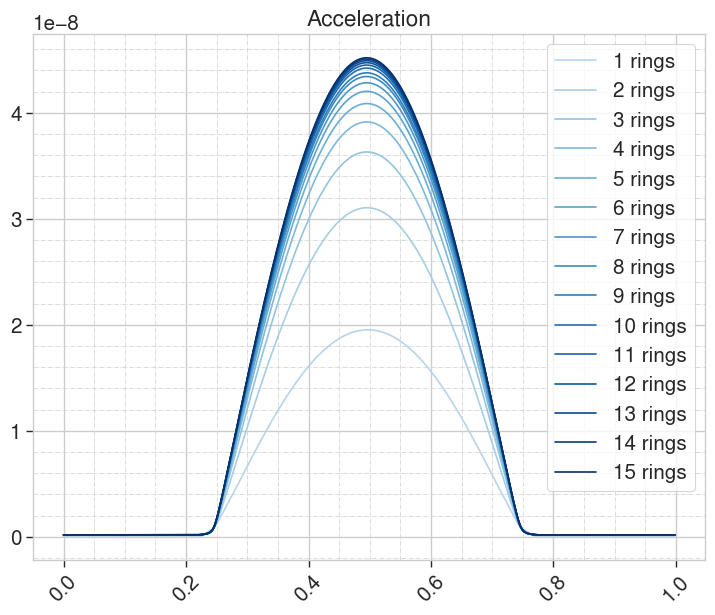

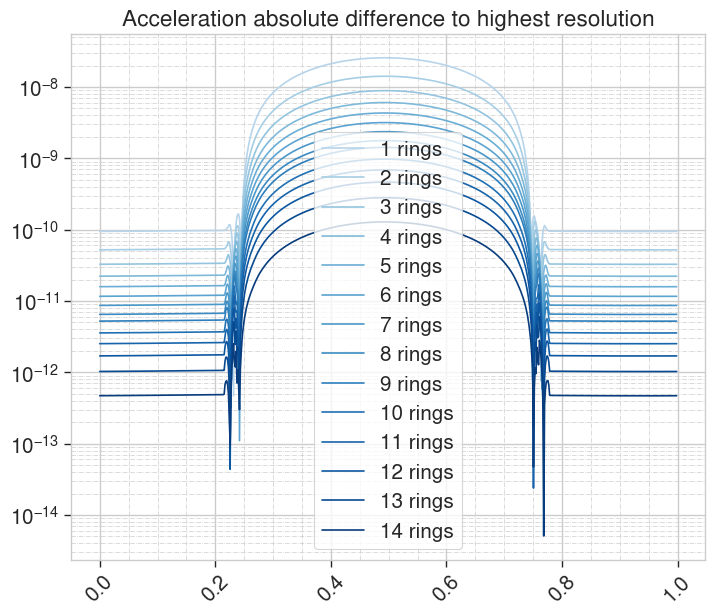

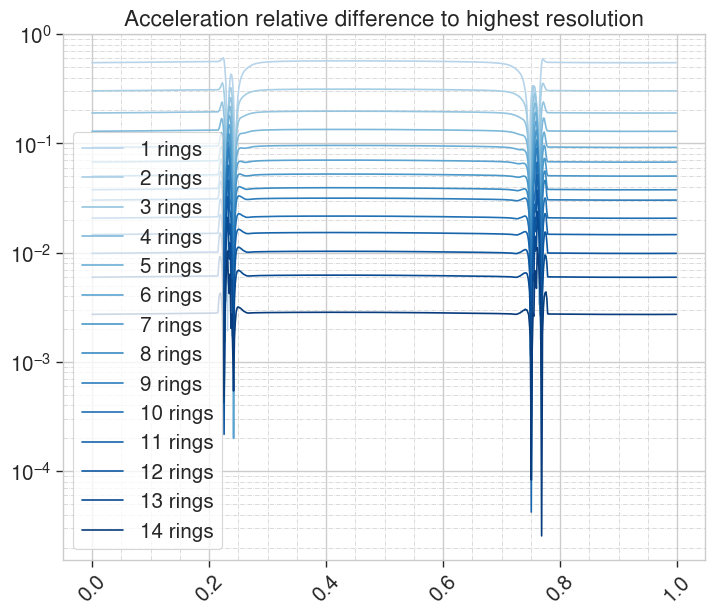

In [44]:
dfs_convergence = get_dfs_rings("Constant")
plot_convergence_magnitude(dfs_convergence.values(), dfs_convergence.keys())
plot_convergence_error(dfs_convergence.values(), dfs_convergence.keys())
plot_convergence_error_relative(dfs_convergence.values(), dfs_convergence.keys())

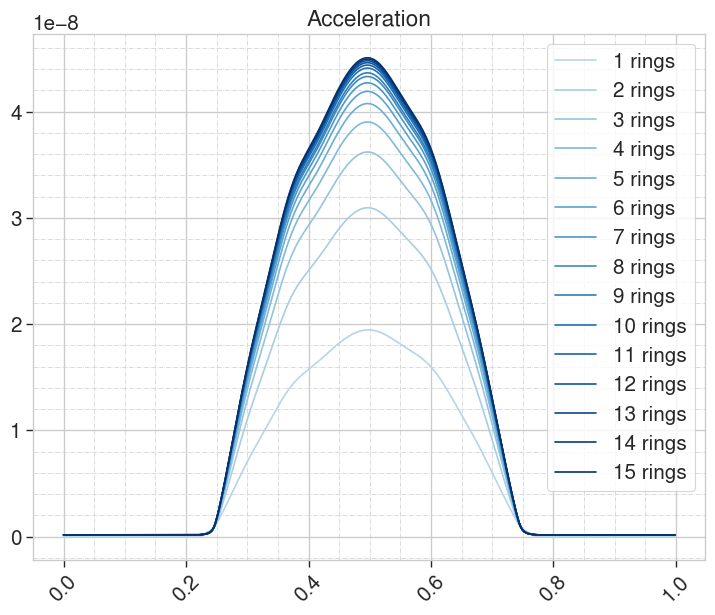

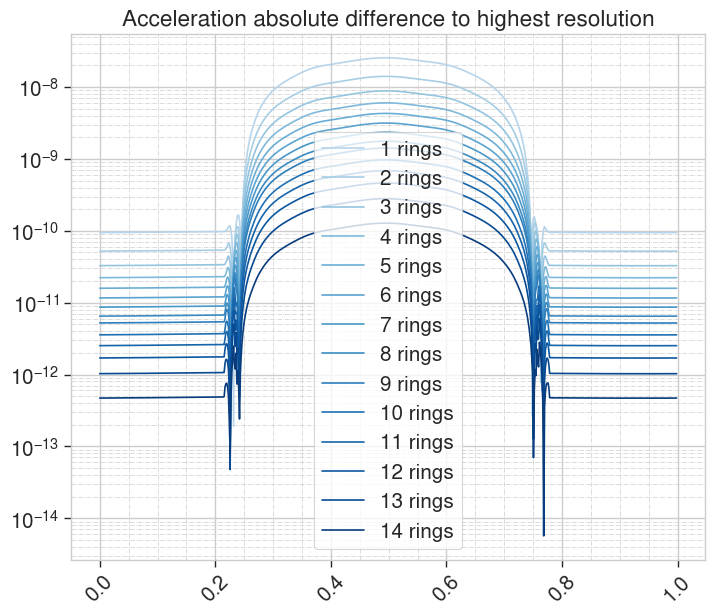

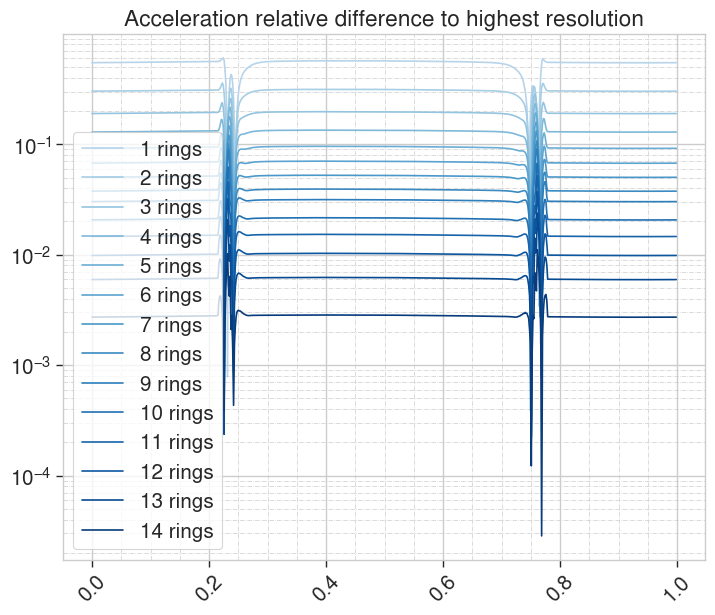

In [45]:
dfs_convergence = get_dfs_rings("DLAM1")
plot_convergence_magnitude(dfs_convergence.values(), dfs_convergence.keys())
plot_convergence_error(dfs_convergence.values(), dfs_convergence.keys())
plot_convergence_error_relative(dfs_convergence.values(), dfs_convergence.keys())